In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc import nircam_dark

from pynrc.reduce.calib import find_sat, cube_fit
from pynrc.nrc_utils import jl_poly_fit, jl_poly

from pynrc.reduce import calib, ref_pixels
from pynrc.detops import create_detops
from pynrc.maths import robust

from pynrc.maths.image_manip import hist_indices, binned_statistic
from pynrc.reduce.calib import chisqr_red, get_fits_data, ramp_derivative

In [4]:
from astropy.io import fits

In [5]:
from scipy import optimize

def fit_bootstrap(pinit, datax, datay, function, yerr_systematic=0.0, nrand=1000, return_more=False):
    """Bootstrap fitting routine
    
    Bootstrap fitting algorithm to determine the uncertainties on the fit parameters.
    
    Parameters
    ----------
    pinit : ndarray
        Initial guess for parameters to fit
    datax, datay : ndarray
        X and y values of data to be fit
    function : func
        Model function 
    yerr_systematic : float or array_like of floats
        Systematic uncertainites on contributing to additional error in data. 
        This is treated as independent Normal error on each data point.
        Can have unique values for each data point. If 0, then we just use
        the standard deviation of the residuals to randomize the data.
    nrand : int
        Number of random data sets to generate and fit.
    return_all : bool
        If true, then also return the full set of fit parameters for the randomized
        data to perform a more thorough analysis of the distribution. Otherewise, 
        just reaturn the mean and standard deviations.
    """

#     errfunc = lambda p, x, y: function(x,p) - y
    def errfunc(p, x, y):
        return function(x, p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, pinit, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # Some random data sets are generated and fitted
    randomdataY = datay + np.random.normal(scale=sigma_err_total, size=(nrand, len(datay)))
    ps = []
    for i in range(nrand):

#         randomDelta = np.random.normal(0., sigma_err_total, len(datay))
#         datay_rand = datay + randomDelta
    
        datay_rand = randomdataY[i]
        randomfit, randomcov = optimize.leastsq(errfunc, pinit, args=(datax, datay_rand), full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,axis=0)
    err_pfit = np.std(ps,axis=0)
    
    if return_more:
        return mean_pfit, err_pfit, ps
    else:
        return mean_pfit, err_pfit

# NIRCam Dark Info

In [6]:
# Init NIRCam dark
datadir='/Users/jarron/NIRCam/Data/CV3_Darks/'
outdir='/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(485, datadir, outdir)

[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5


In [7]:
# Dark ramp/slope info

# Dark slope and bias images
dark_data.get_dark_slope_image()
dark_data.get_super_bias_update()

# Get IPC/PPC kernels
dark_data.get_ipc(calc_ppc=True)

# Deconvolve the super dark and super bias images
dark_data.deconvolve_supers()

[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Generating initial super bias
[     pynrc:INFO] Opening updated super bias
[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO]   IPC = 0.597% +/- 0.004%
[     pynrc:INFO]   PPC = 0.123% +/- 0.010%
[     pynrc:INFO] Deconvolving super dark and super bias images...


In [8]:
# Noise dictionary
dark_data.get_cds_dict()

[     pynrc:INFO] Building CDS Noise dictionaries...


# NIRCam Linearity Data

In [9]:
import os 

datadir='/Users/jarron/NIRCam/Data/CV3_Linearity/'
outdir='/Users/jarron/NIRCam/dark_analysis/CV3/'
scaid = 485

# Directory information
indir = os.path.join(datadir, str(scaid)) + '/'
# Get file names within directory
allfits = [file for file in os.listdir(indir) if file.endswith('.fits')]
allfits = np.sort(allfits)
# Add directory 
allfiles = [indir + f for f in allfits]

nfiles = len(allfiles)

In [10]:
hdr = fits.getheader(allfiles[0])

DMS=False
same_scan_direction=False
reverse_scan_direction=False

det = create_detops(hdr, DMS=DMS)

[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5


In [11]:
# Dimensions
nz, ny, nx = (det.multiaccum.ngroup, det.ypix, det.xpix)
nchan = det.nout
chsize = int(nx / nchan)

# Time array
tarr = det.times_group_avg

In [12]:
# Active and reference pixel masks
lower, upper, left, right = det.ref_info

mask_ref = np.zeros([ny,nx], dtype='bool')
if lower>0: mask_ref[0:lower,:] = True
if upper>0: mask_ref[-upper:,:] = True
if left>0:  mask_ref[:,0:left] = True
if right>0: mask_ref[:,-right:] = True
mask_act = ~mask_ref

## Delta Photon Transfer

In [118]:
# Frame 1
file = allfiles[1]
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'top_ref' : True
}

# Reference pixel correction, amplifiers corrections only
data = get_fits_data(file, bias=None, reffix=True, grp_ind=[0,108], **kwargs_ref)

# Get frame-by-frame differences to determine bias offset
yvals_fit = data[0:20]
dy = ramp_derivative(yvals_fit, fit0=True, deg=2, ifit=[0,15])
# Cumulative sum
yfit = np.cumsum(dy, axis=0)
# Determine bias offsets
bias = yvals_fit[0] - yfit[0]

# Fix values that are too high 
data -= bias
vals_max = np.max(data, axis=0)
ind_high = vals_max > (2**16 - 1)
bias[ind_high] = 0

del data, dy, yfit, yvals_fit


# Reference pixel correction and bias subtraction
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'top_ref' : True
}

# Read in data and trim to 108
data = get_fits_data(file, bias=bias, reffix=True, grp_ind=[0,108], **kwargs_ref)

# Update number of read frames
nz, ny, nx = data.shape
det.multiaccum.ngroup = nz
tarr = det.times_group_avg

# IPC correction
ipc_big = nrc_utils.pad_or_cut_to_size(dark_data.kernel_ipc, (ny,nx))
kfft = np.fft.fft2(ipc_big)
for i in trange(nz, leave=False):
    data[i] = calib.ipc_deconvolve(data[i], dark_data.kernel_ipc, kfft=kfft)

data1 = data

In [119]:
# Frame 2
file = allfiles[3]
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'top_ref' : True
}

# Reference pixel correction, amplifiers corrections only
data = get_fits_data(file, bias=None, reffix=True, grp_ind=[0,108], **kwargs_ref)

# Get frame-by-frame differences to determine bias offset
yvals_fit = data[0:20]
dy = ramp_derivative(yvals_fit, fit0=True, deg=2, ifit=[0,15])
# Cumulative sum
yfit = np.cumsum(dy, axis=0)
# Determine bias offsets
bias = yvals_fit[0] - yfit[0]

# Fix values that are too high 
data -= bias
vals_max = np.max(data, axis=0)
ind_high = vals_max > (2**16 - 1)
bias[ind_high] = 0

del data, dy, yfit, yvals_fit


# Reference pixel correction and bias subtraction
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'top_ref' : True
}

# Read in data and trim to 108
data = get_fits_data(file, bias=bias, reffix=True, grp_ind=[0,108], **kwargs_ref)

# Update number of read frames
nz, ny, nx = data.shape
det.multiaccum.ngroup = nz
tarr = det.times_group_avg

# IPC correction
ipc_big = nrc_utils.pad_or_cut_to_size(dark_data.kernel_ipc, (ny,nx))
kfft = np.fft.fft2(ipc_big)
for i in trange(nz, leave=False):
    data[i] = calib.ipc_deconvolve(data[i], dark_data.kernel_ipc, kfft=kfft)

data2 = data

In [120]:
def calc_gain(cube1, cube2, nchan=4, rn_arr=[5,5,5,5], reffix=False, 
              mn_func=np.median, std_func=robust.std, **kwargs):
        
    ny, nx = cube1.shape[-2:]
    chsize = int(nx / nchan)
                    
    # Reference correction
    if reffix:
        # Calculate consecutive frame differences
#         diff1 = cube1[1::2] - cube1[0::2]
#         diff2 = cube2[1::2] - cube2[0::2]
        diff1 = cube1[2::2] - cube1[0:-2:2]
        diff2 = cube2[2::2] - cube2[0:-2:2]

        # Default kwargs to run
        kwargs_def = {
            'nchans': nchan, 'altcol': True, 'in_place': True,    
            'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
        }
        # Include defaults if keyword not specified
        for k in kwargs_def.keys():
            if k not in kwargs:
                kwargs[k] = kwargs_def[k]
        
        diff1 = ref_pixels.reffix_hxrg(diff1, **kwargs)
        diff2 = ref_pixels.reffix_hxrg(diff2, **kwargs)
            
    gain_ch = []
    sig_ch = []
    for ch in trange(nchan):
        y1, y2 = (4, ny-4)
        x1 = ch*chsize + 4
        x2 = x1 + chsize - 8
        
        if not reffix:
            # Calculate consecutive frame differences
#             diff1 = cube1[1::2,y1:y2,x1:x2] - cube1[0::2,y1:y2,x1:x2]
#             diff2 = cube2[1::2,y1:y2,x1:x2] - cube2[0::2,y1:y2,x1:x2]
            diff1 = cube1[2::2,y1:y2,x1:x2] - cube1[0:-2:2,y1:y2,x1:x2]
            diff2 = cube2[2::2,y1:y2,x1:x2] - cube2[0:-2:2,y1:y2,x1:x2]
            
            vals = 0.5 * (diff1 + diff2) # Average flux values for each delta
            diff = diff1 - diff2         # Subtract to calculate pixel variance
        else:
            # Get average flux values 
            vals = 0.5 * (diff1[:,y1:y2,x1:x2] + diff2[:,y1:y2,x1:x2])
            # Subtract to calculate pixel variance
            diff = diff1[:,y1:y2,x1:x2] - diff2[:,y1:y2,x1:x2]
        
        vals = vals[:, 1000:1200, 200:400]
        diff = diff[:, 1000:1200, 200:400]
        
        vals_avg = mn_func(vals.reshape([vals.shape[0],-1]), axis=1)
        diff_var = std_func(diff.reshape([diff.shape[0],-1]), axis=1)**2
        
        # Calculate gain
        num = 2 * vals_avg
        den = diff_var + 4*rn_arr[ch]**2
        gain_vals = num / den
        
        # Signal levels associated with each gain measurement
#         data_mn = (cube1[1::2,y1:y2,x1:x2] + cube1[0::2,y1:y2,x1:x2] + 
#                    cube2[1::2,y1:y2,x1:x2] + cube2[0::2,y1:y2,x1:x2]) / 4
        data_mn = (cube1[2::2,y1:y2,x1:x2] + cube1[0:-2:2,y1:y2,x1:x2] + 
                   cube2[2::2,y1:y2,x1:x2] + cube2[0:-2:2,y1:y2,x1:x2]) / 4
        data_mn = data_mn[:, 1000:1200, 200:400]
        sig_mn = mn_func(data_mn.reshape([data_mn.shape[0],-1]), axis=1)
        
        gain_ch.append(gain_vals)
        sig_ch.append(sig_mn)
        
    gain_ch = np.array(gain_ch)
    sig_ch = np.array(sig_ch)
    
    return sig_ch, gain_ch

In [130]:
cds_dict = dark_data.calc_cds_noise(cds_type='spatial')
rn_arr = np.sqrt((cds_dict['white']**2 + cds_dict['pink_uncorr']**2) / 2)
# rn_arr=[5,4.3,3.8,3.8]

sig_ch, gain_ch = calc_gain(data1, data2, reffix=False, rn_arr=rn_arr,
                            mn_func=np.mean, std_func=robust.std)

Text(0.5, 1.0, 'Gain Values (SCA 485, IPC Corrected)')

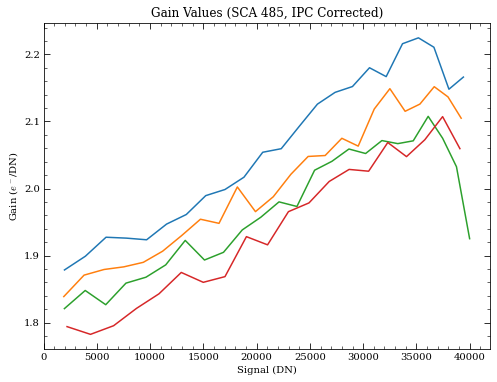

In [131]:
for ch in np.arange(nchan):
    x = sig_ch[ch]
    y = gain_ch[ch]
    
    ind = x<40000
    plt.plot(x[ind], y[ind])
    
plt.xlabel('Signal (DN)')
plt.ylabel('Gain ($e^-$/DN)')
plt.title('Gain Values (SCA 485, IPC Corrected)')

Text(0.5, 1.0, 'Gain Values (SCA 485, IPC Corrected)')

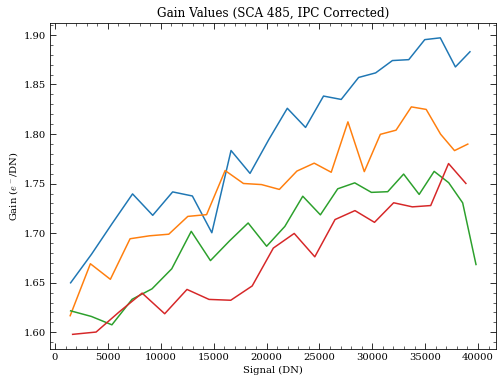

In [97]:
for ch in np.arange(nchan):
    x = sig_ch[ch]
    y = gain_ch[ch]
    
    ind = x<40000
    plt.plot(x[ind], y[ind])
    
plt.xlabel('Signal (DN)')
plt.ylabel('Gain ($e^-$/DN)')
plt.title('Gain Values (SCA 485, IPC Corrected)')

Text(0.5, 1.0, 'Gain Values (SCA 485, IPC Corrected)')

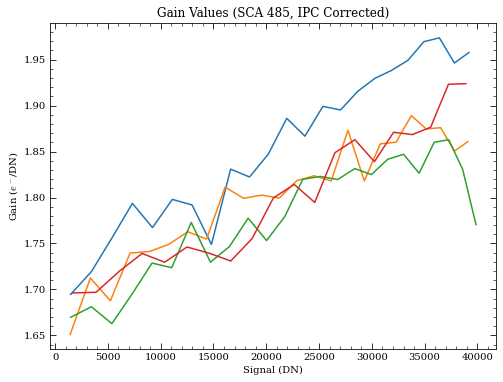

In [87]:
for ch in np.arange(nchan):
    x = sig_ch[ch]
    y = gain_ch[ch]
    
    ind = x<40000
    plt.plot(x[ind], y[ind])
    
plt.xlabel('Signal (DN)')
plt.ylabel('Gain ($e^-$/DN)')
plt.title('Gain Values (SCA 485, IPC Corrected)')

In [65]:
cds_dict

{'tot': array([8.28480124, 8.30536553, 8.67587035, 9.68709828]),
 'white': array([5.81873631, 5.62183303, 6.24479783, 7.49168356]),
 'pink_uncorr': array([2.04081239, 2.36904956, 2.11915135, 2.33712897]),
 'pink_corr': 5.597768194415831,
 'ref_ratio': 0.9497645181898414}

In [66]:
np.sqrt((cds_dict['white']**2 + cds_dict['pink_corr']**2) / 2)

array([5.70932137, 5.60981351, 5.93011419, 6.61287877])

In [70]:
rn_arr

array([5.70932137, 5.60981351, 5.93011419, 6.61287877])

Text(0.5, 1.0, 'Gain Values (SCA 485, IPC Corrected)')

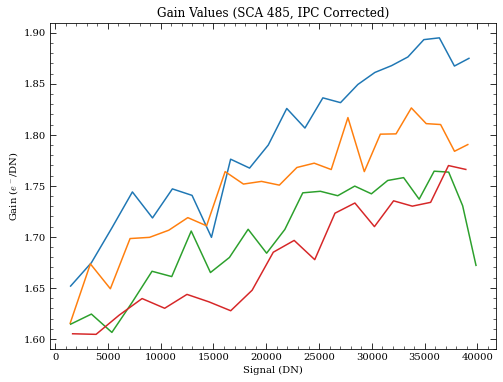

In [89]:
for ch in np.arange(nchan):
    x = sig_ch[ch]
    y = gain_ch[ch]
    
    ind = x<40000
    plt.plot(x[ind], y[ind])
    
plt.xlabel('Signal (DN)')
plt.ylabel('Gain ($e^-$/DN)')
plt.title('Gain Values (SCA 485, IPC Corrected)')

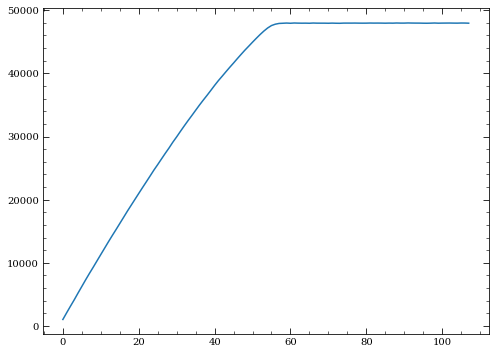

In [56]:
plt.plot(data1[:,100,100])

In [15]:
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True
}
diff1 = ref_pixels.reffix_hxrg(diff1, **kwargs_ref)
diff2 = ref_pixels.reffix_hxrg(diff2, **kwargs_ref)

In [16]:
diff_avg = 0.5 * (diff1 + diff2)
del_diff = diff1 - diff2

In [17]:
x1, x2 = (4, 512)
y1, y2 = (4, 2000)

In [18]:
dsig_avg = np.mean(diff_avg[:,y1:y2,x1:x2], axis=(1,2))
dsig_avg2 = robust.mean(diff_avg[:,y1:y2,x1:x2], axis=(1,2))

In [19]:
diff_var = np.std(del_diff[:,y1:y2,x1:x2], axis=(1,2))**2
diff_var2 = robust.medabsdev(del_diff[:,y1:y2,x1:x2], axis=(1,2))**2

In [20]:
sig_mn = np.median(0.5*(data[1::2,y1:y2,x1:x2] + data[0::2,y1:y2,x1:x2]), axis=(1,2))

In [20]:
ch = 0
cds_dict = dark_data.calc_cds_noise(cds_type='spatial')
var_rn = cds_dict['tot'][ch]**2 / 2

In [23]:
cds_dict['tot'] / np.sqrt(2)

array([5.85823914, 5.87278029, 6.13476676, 6.84981288])

In [22]:
# Calculate gain
num = 2 * dsig_avg
den = diff_var + 4*var_rn
gain_vals = num / den

# Calculate gain
num2 = 2 * dsig_avg2
den2 = diff_var2 + 4*var_rn
gain_vals2 = num2 / den2

In [30]:
gain_vals2.shape

(54,)

Text(0, 0.5, 'Gain ($e^-$/DN)')

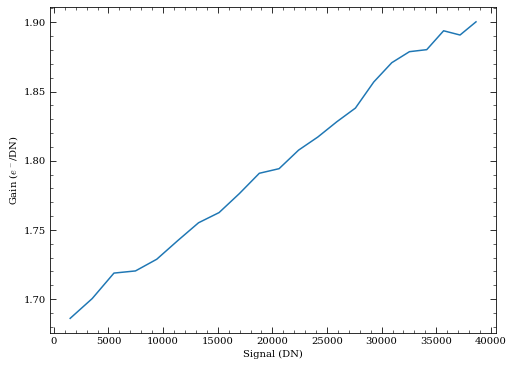

In [27]:
ind = sig_mn<40000
# plt.plot(sig_mn[ind], gain_vals[ind])
plt.plot(sig_mn[ind], gain_vals2[ind])
plt.xlabel('Signal (DN)')
plt.ylabel('Gain ($e^-$/DN)')

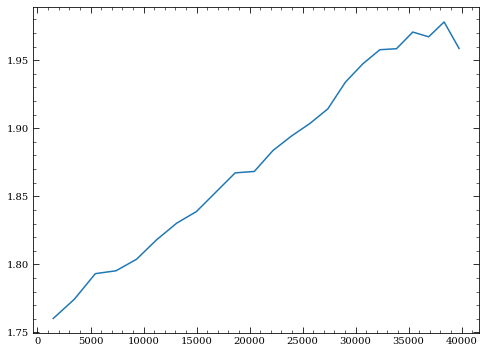

In [123]:
ind = sig_mn<40000
# plt.plot(sig_mn[ind], gain_vals[ind])
plt.plot(sig_mn[ind], gain_vals2[ind])

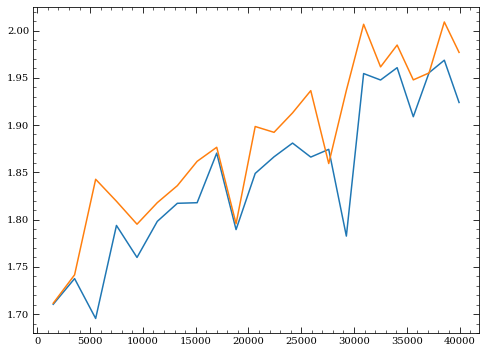

In [93]:
ind = sig_mn<40000
plt.plot(sig_mn[ind], gain_vals[ind])
plt.plot(sig_mn[ind], gain_vals2[ind])

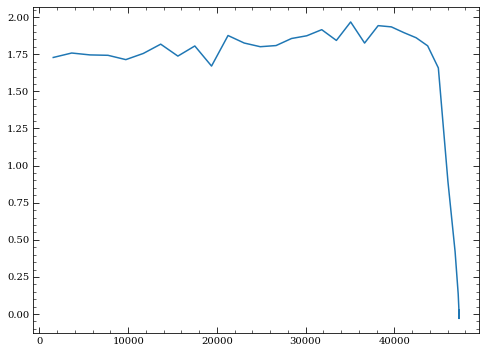

In [32]:
plt.plot(sig_mn, gain_vals)

In [14]:
# import gc
# gc.collect()

In [110]:
# Get saturation levels
sat_vals = find_sat(data2)

In [111]:
print(np.median(sat_vals), robust.medabsdev(sat_vals))

for ch in range(nchan):
    x1 = ch*chsize
    x2 = x1 + chsize
    print(np.median(sat_vals[:,x1:x2]), robust.medabsdev(sat_vals[:,x1:x2]))

46063.004082462416 1059.8823462618602
47163.350539332096 885.9728033853149
45730.8033669002 854.1653867591085
45437.187647774335 875.9811377737782
46001.99969408882 769.3561406307256


In [28]:
# Histogram of saturation values (active pixels only)
im = sat_vals[mask_act]
binsize = 10
bins = np.arange(im.min(), im.max() + binsize, binsize)
ig, vg, cv = hist_indices(im, bins=bins, return_more=True)

# Find pixels at the peak binsize
nvals = np.array([len(i) for i in ig])
ind_nvals_max = np.where(nvals==nvals.max())[0][0]
ig_good = ig[ind_nvals_max]

Text(0, 0.5, 'Number of Pixels')

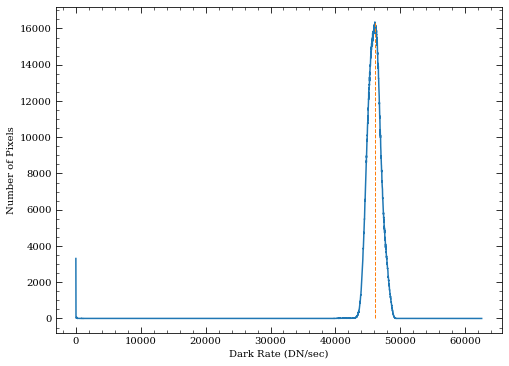

In [29]:
max_dn = cv[ind_nvals_max]
max_npix = nvals[ind_nvals_max]

plt.plot(cv, nvals)
plt.plot(2*[max_dn], [0,max_npix], ls='--', lw=1)
plt.xlabel('Dark Rate (DN/sec)')
plt.ylabel('Number of Pixels')


In [42]:
ind = (sat_vals >= max_dn-0.5) & (sat_vals <= max_dn+0.5)
data_weird = data[:, ind]

In [53]:
diff_arr = data[1:] - data[0:-1]
diff_max = np.median(diff_arr[0]) / 10
diff_min = 100

In [55]:
sat_mask = (diff_arr[0]>diff_max) & (np.abs(diff_arr[-1]) < diff_min)

In [57]:
sat_med = np.median(data[-1][sat_mask])

In [59]:
max_dn

46001.21742613877

In [58]:
sat_med

46001.12261189634

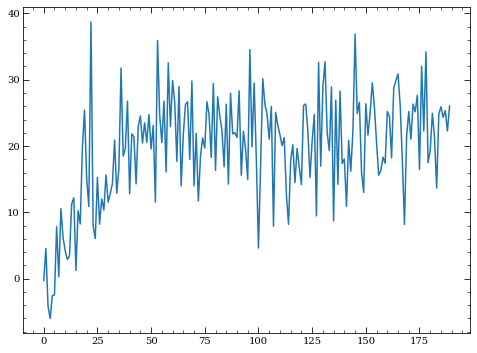

In [48]:
plt.plot(data_weird[:,5]);

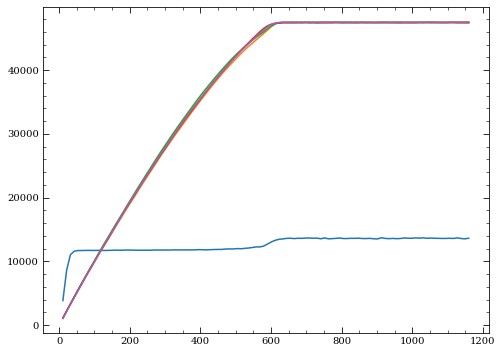

In [14]:
plt.plot(tarr, data[:,19,49])

plt.plot(tarr, data[:,19,50])
plt.plot(tarr, data[:,19,48])

plt.plot(tarr, data[:,18,49])
plt.plot(tarr, data[:,20,49])

In [22]:
bias_off[19,49]

-950.6079564959732

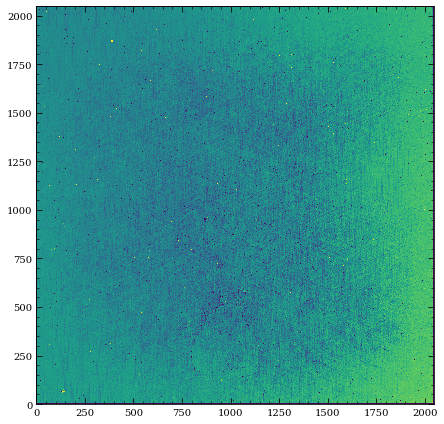

In [39]:
im = data[10] - bias_off
mn = np.median(im)
std = robust.medabsdev(im)
vmin = mn - 5*std
vmax = mn + 5*std

fig, ax = plt.subplots(1,1)
ax.imshow(im, vmin=vmin, vmax=vmax)

fig.tight_layout()

In [46]:
# Get saturation levels
sat_vals = find_sat(data)

# Fit up to 95% of saturation
cf = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=0.25, deg=2)
bias, slope, _ = cf

In [45]:
# Subtract bias and refit
data -= bias

# Fit up to 95% of saturation
cf = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=0.95, deg=2)
bias, slope, _ = cf

In [29]:
yvals_fit = data[0:100,19,49]
dy = ramp_derivative(yvals_fit, fit0=True, deg=2, ifit=[0,10])

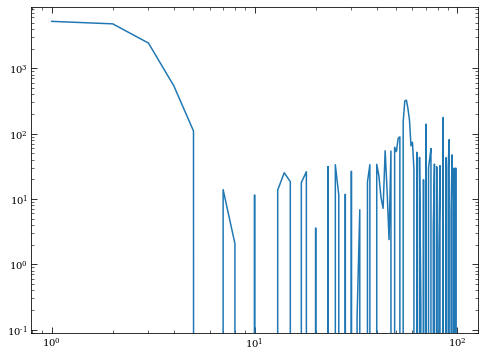

In [32]:
plt.loglog(np.arange(len(dy))+1, dy)

In [70]:
yfit = np.cumsum(dy, axis=0)

In [71]:
yvals_fit[0] - yfit[0]

29.35212424464271

(-500.0, 5000.0)

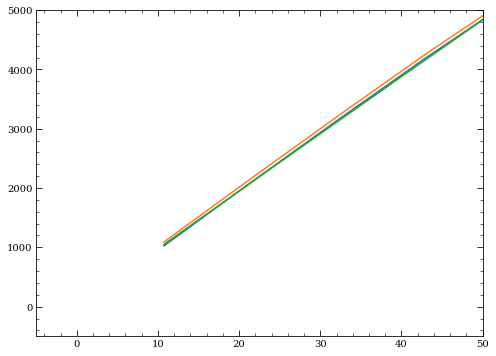

In [53]:
x = tarr[0:15]
plt.plot(x, yvals_fit)
plt.plot(x, yfit)

plt.plot(x, jl_poly(x, cf[:,100,100]))

plt.xlim([-5,50])
plt.ylim([-500,5000])

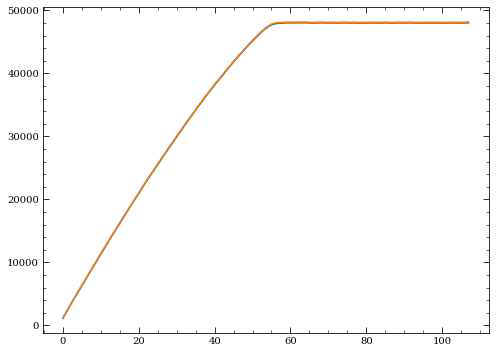

In [27]:
plt.plot(yfit)
plt.plot(data[:,100,100])

0.46845396943977485


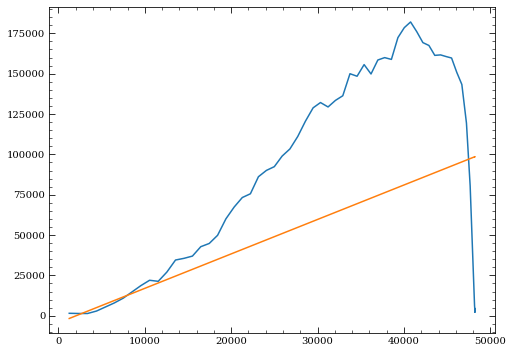

In [29]:
xpix, ypix = (100,100)
x, y = (ramp_avg[:,ypix,xpix], ramp_var[:,ypix,xpix])

ifit = (x>0) & (x<10000)
cf = jl_poly_fit(x[ifit], y[ifit])
yfit = jl_poly(x,cf)

plt.plot(x, y)
plt.plot(x, yfit)

print(1/cf[1])

## Super Bias from linearity data

In [15]:
kwargs_ref = {
    'nchans': nchan, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True
}

# Create a superbias
bias_all = []
for i in trange(nfiles):
    data = get_fits_data(allfiles[i], reffix=True, **kwargs_ref)
    
    sat_vals = find_sat(data)
    cf = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=0.95, deg=2)

    bias_all.append(cf[0])
    del data
    
bias_all = np.array(bias_all)

In [16]:
super_bias = np.mean(bias_all, axis=0)

In [17]:
# lxmap = [0,tarr.max()]
# use_legendre = False

# sat_vals = find_sat(data)
# cf = cube_fit(tarr[1:100], data[1:], sat_vals=sat_vals, sat_frac=0.95, 
#               fit_zero=False, use_legendre=use_legendre, lxmap=lxmap, deg=2)

In [19]:
res = gen_super_ramp(allfiles, super_bias=super_bias, **kwargs_ref)
super_ramp, bias_off, masks_dict = res

[     pynrc:INFO] RAPID readout mode selected.
[     pynrc:INFO] Setting nf=1, nd1=0, nd2=0, nd3=0.
[     pynrc:INFO] Initializing SCA 485/A5


In [41]:
fname_super_ramp = outdir + f'SUPER_LIN_RAMP/SUPER_LIN_RAMP_{scaid}.FITS'

# Save super dark ramp
hdu = fits.PrimaryHDU(super_ramp)
# hdu = fits.PrimaryHDU(super_dark_ramp)
hdu.writeto(fname_super_ramp, overwrite=True)

In [76]:
data = super_ramp
sat_vals = find_sat(data)
cf = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=0.8, deg=2)
super_slope = cf[1]

In [77]:
# Histogram of Dark Slope
im = super_slope
binsize = 1
bins = np.arange(im.min(), im.max() + binsize, binsize)
ig, vg, cv = nrc_utils.hist_indices(im, bins=bins, return_more=True)

# Choose only those pixels at the peak binsize
nvals = np.array([len(i) for i in ig])
ind_nvals_max = np.where(nvals==nvals.max())[0][0]
ig_good = ig[ind_nvals_max]

bg_max_dn = cv[ind_nvals_max]

In [78]:
# Histogram of saturation values
im = sat_vals[sat_vals<65000]
binsize = 100
bins = np.arange(im.min(), im.max() + binsize, binsize)
ig, vg, cv = nrc_utils.hist_indices(im, bins=bins, return_more=True)

# Choose only those pixels at the peak binsize
nvals = np.array([len(i) for i in ig])
ind_nvals_max = np.where(nvals==nvals.max())[0][0]
ig_good = ig[ind_nvals_max]

sat_max_dn = cv[ind_nvals_max]

In [87]:
mask_sat = (sat_vals>sat_max_dn-100) & (sat_vals<sat_max_dn+100)
mask_slope = (super_slope>bg_max_dn-1) & (super_slope<bg_max_dn+1)

ind_good = mask_sat & mask_slope

In [88]:
np.sum(ind_good)

39416

In [89]:
data_good = data[:,ind_good]

(-10.0, 600.0)

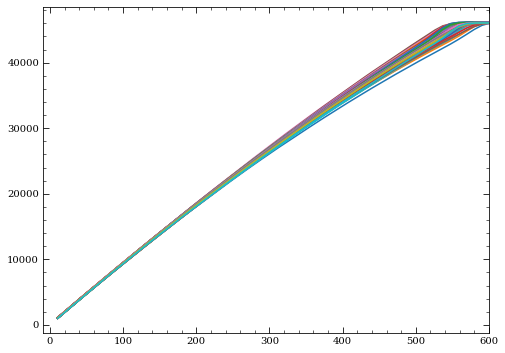

In [90]:
plt.plot(tarr, data_good[:,0:100])
plt.xlim([-10,600])

In [24]:
# Create a super slope image
slope_all = []
avg_slope = []
super_ramp = []
for i in trange(nfiles):
    f = allfiles[i]
    hdul = fits.open(f)

    data = hdul[0].data[0:100].astype(np.float)
    hdul.close()
    
    data -= super_bias
    data = ref_pixels.reffix_hxrg(data, nchans=4, altcol=True, in_place=True, 
                                  fixcol=True, avg_type='int', savgol=True, perint=False)
    
    sat_vals = find_sat(data)
    cf = cube_fit(tarr[1:], data[1:], sat_vals=sat_vals, sat_frac=0.95, deg=2)
    
    slope_all.append(cf[1])
    
    # Get median of all pixels at each time step
    vals = np.median(data.reshape([nz,-1]), axis=1)
    # Remove offset
    ifit = (tarr>tarr[0]) & (vals<0.95*np.mean(sat_vals))
    cf = jl_poly_fit(tarr[ifit], vals[ifit], deg=2)
    avg_slope.append(vals - cf[0])

slope_all = np.array(slope_all)
avg_slope = np.array(avg_slope)
# get average slope
ramp_avg = np.median(avg_slope, axis=0)

NRCN815A-LIN-6015154047_1_485_SE_2016-01-15T16h25m59.fits
NRCN815A-LIN-6015161908_2_485_SE_2016-01-15T17h00m39.fits
NRCN815A-LIN-6015165350_3_485_SE_2016-01-15T17h35m17.fits
NRCN815A-LIN-6015172836_4_485_SE_2016-01-15T18h09m55.fits
NRCN815A-LIN-6015180318_5_485_SE_2016-01-15T18h44m38.fits
NRCN815A-LIN-6015183800_6_485_SE_2016-01-15T19h19m26.fits
NRCN815A-LIN-6015191241_7_485_SE_2016-01-15T19h54m09.fits
NRCN815A-LIN-6015194727_8_485_SE_2016-01-15T20h41m36.fits


In [30]:
super_slope  = np.mean(slope_all, axis=0)

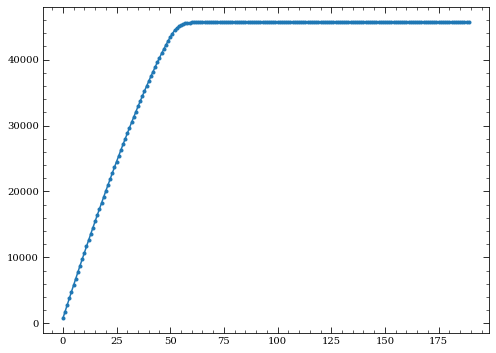

In [85]:
# Check linearity over flux range
plt.plot(tarr, ramp_avg, marker='.')
plt.xlim([-50,1000])

# Gain

In [32]:
# Histogram of Dark Slope
im = super_slope
binsize = 1
bins = np.arange(im.min(), im.max() + binsize, binsize)
ig, vg, cv = nrc_utils.hist_indices(im, bins=bins, return_more=True)

# Choose only those pixels at the peak binsize
nvals = np.array([len(i) for i in ig])
ind_nvals_max = np.where(nvals==nvals.max())[0][0]
ig_good = ig[ind_nvals_max]

(0.0, 200.0)

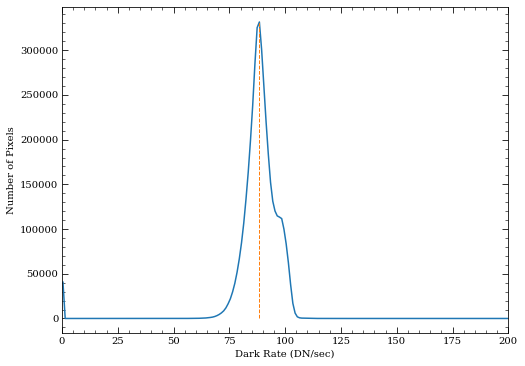

In [35]:
bg_max_dn = cv[ind_nvals_max]
#bg_max_e = bg_max_dn * gain
bg_max_npix = nvals[ind_nvals_max]

plt.plot(cv, nvals)
plt.plot(2*[bg_max_dn], [0,bg_max_npix], ls='--', lw=1)
plt.xlabel('Dark Rate (DN/sec)')
plt.ylabel('Number of Pixels')

plt.xlim([0,200])

#print('Dark Current = {:.1f} DN/sec ({:.1f} e-/sec)'.format(bg_max_dn, bg_max_e))

In [69]:
mask_good = np.zeros([ny,nx], dtype='bool')
mask_good.flat[ig_good] = True

In [102]:
# For each ramp, obtain the average signal and variance of pixels
# within the maximum DN/sec bin
sig_all = []
var_all = []
# mask_good = np.zeros([ny,nx], dtype='bool')
# mask_good.flat[ig_good] = True

mask_good = ind_good

for i in trange(nfiles):
    data = get_fits_data(allfiles[i], return_header=False, bias=super_bias,
                         reffix=True, **kwargs_ref)

    data = data[1:] - data[0]

#     data_good = data.reshape([data.shape[0],-1])[:,ig_good]
#     mgood = mask_good[500:1500,500:1500]
#     data_good = data[:, 500:1500, 500:1500][:,mgood]
#     data_good = data[:,mask_good]
    data_good = data[:, 500:1500, 500:1500]
    x = np.median(data_good, axis=1)
    y = robust.std(data_good, axis=1)**2
    
    sig_all.append(x)
    var_all.append(y)

sig_all = np.array(sig_all)
var_all = np.array(var_all)

In [103]:
sig_mean = np.mean(sig_all, axis=0)
var_mean = np.mean(var_all, axis=0)

KeyboardInterrupt: 

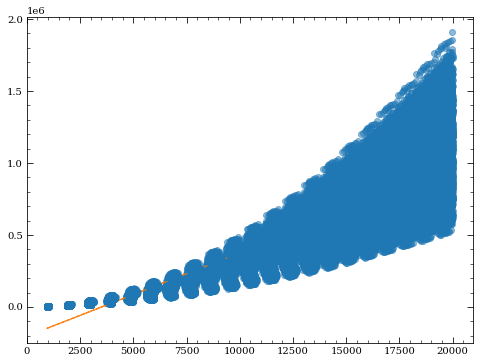

In [104]:
# Fit individual curves
fig, ax = plt.subplots(1,1)

deg = 1
# cf = jl_poly_fit(x, y, deg=deg)
gain_arr = []
_gain_arr = []
for x, y in zip(sig_all, var_all):
    ifit = x<20000
    x = x[ifit]
    y = y[ifit]
    ax.plot(x, y, marker='o', ls='none', lw=1, color='C0', alpha=0.5)
    
    pinit = jl_poly_fit(x, y, deg=deg)
    pfit, perr = fit_bootstrap(pinit, x, y, jl_poly)
    
    #ax.plot(x, jl_poly(x, pfit))
    # Plot linear component only
    ax.plot(x, jl_poly(x, pfit[0:2]), ls='--', lw=1, color='C1', alpha=0.5)
    
    gain_arr.append(1/pfit[1])
    _gain_arr.append(perr[1]/pfit[1]**2)
gain_arr = np.array(gain_arr)
_gain_arr = np.array(_gain_arr)

x, y = sig_mean, var_mean
ifit = x<20000
x = x[ifit]
y = y[ifit]
ax.plot(x, y, marker='o', color='C0')
pinit = jl_poly_fit(x, y, deg=deg)
pfit, perr = fit_bootstrap(pinit, x, y, jl_poly)
ax.plot(x, jl_poly(x, pfit[0:2]), color='C1')

ax.set_xlabel('Signal')
ax.set_ylabel('Variance')

ax.set_xlim(0,ax.get_xlim()[1])
ax.set_ylim(0,ax.get_ylim()[1])

fig.tight_layout()

In [99]:
alpha = det.IPC / 100
gain_fact = 1 + 8*alpha + 52*alpha**2
print(gain_arr / gain_fact)
print(_gain_arr / gain_fact)

[0.40438157 0.44303514 0.45263074 0.46361442 0.48239851 0.47997151
 0.4741163  0.46982379]
[0.02569968 0.02547953 0.02486642 0.02633019 0.02436402 0.02680254
 0.02727636 0.02479946]


In [100]:
# Fit combined curves
sig_mean = np.mean(sig_all, axis=0)
var_mean = np.mean(var_all, axis=0)

ifit = sig_mean<20000
pinit = jl_poly_fit(sig_mean[ifit], var_mean[ifit], deg=deg)
pfit, perr = fit_bootstrap(pinit, sig_mean[ifit], var_mean[ifit], jl_poly, nrand=1000)

gain_uncorr = 1 / pfit[1]
_gain_uncorr = perr[1]/pfit[1]**2

gain_fact = 1 + 8*alpha + 52*alpha**2
gain_corr = gain_uncorr / gain_fact
_gain_corr = _gain_uncorr / gain_fact

_alpha = 0.0001
_gain_fact = _alpha * (8 + 104*alpha)
_gain_corr = (1/gain_fact) * np.sqrt(_gain_uncorr**2 + (_gain_fact*gain_corr)**2)

gain_assumed = 1.84
print("Assumed Gain: {:.3f} e-/DN".format(gain_assumed))
print("Uncorrected Gain: {:.3f} +/- {:.3f}".format(gain_uncorr, _gain_uncorr))
print("Corrected Gain: {:.3f} +/- {:.3f}".format(gain_corr, _gain_corr))

Assumed Gain: 1.840 e-/DN
Uncorrected Gain: 0.468 +/- 0.027
Corrected Gain: 0.446 +/- 0.025


0.5550091022933578 0.028028338994672615


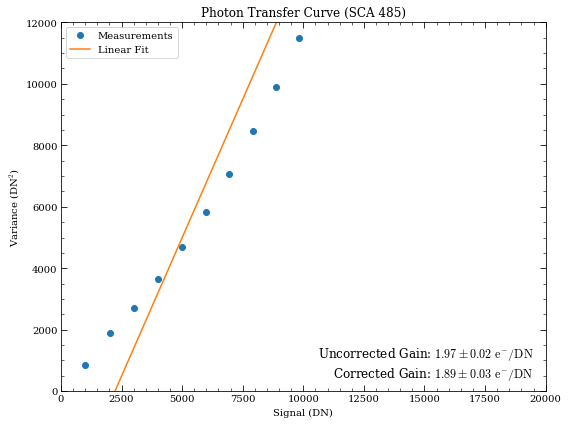

In [101]:
fig, ax = plt.subplots(1,1)
x, y = sig_mean, var_mean

ifit = sig_mean<18000
x, y = (x[ifit], y[ifit])

pinit = jl_poly_fit(x, y, deg=deg)
pfit, perr = fit_bootstrap(pinit, x, y, jl_poly)

print(1/pfit[1], perr[1]/pfit[1]**2)

ax.plot(x, y, marker='o', color='C0', ls='none', label='Measurements')
ax.plot(x, jl_poly(x, pfit[0:2]), color='C1', label='Linear Fit')

ax.set_xlim(0,20000)
ax.set_ylim(0,12000)

gain_txt1 = "Uncorrected Gain: $1.97\pm0.02$ $\mathrm{e^{-}/DN}$"
gain_txt2 = "Corrected Gain: $1.89\pm0.03$ $\mathrm{e^{-}/DN}$"
gain_txt = '{}\n{}'.format(gain_txt1, gain_txt2)

xr = ax.get_xlim()
yr = ax.get_ylim()
xloc = xr[1] - 0.025*(xr[1]-xr[0])
yloc = yr[0] + 0.025*(yr[1]-yr[0])
ax.text(xloc, yloc, gain_txt, fontsize=12, 
        verticalalignment='bottom', horizontalalignment='right')

ax.set_title(f"Photon Transfer Curve (SCA {scaid})")
ax.set_xlabel('Signal (DN)')
ax.set_ylabel('Variance (DN$^2$)')

ax.legend(loc='upper left')

fig.tight_layout()

# if save_figs:
#     fig.savefig(outdir + "Gain_PTC_{}.pdf".format(spd_str))
#     fig.savefig(outdir + "Gain_PTC_{}.png".format(spd_str))

In [46]:
gain_arr

array([1.75340894, 1.76399321, 1.80022665, 1.83044121, 1.83182875,
       1.83136081, 1.83760721, 1.83935743])

In [46]:
lxmap = [0,tarr.max()]
use_legendre = False

sat_vals = find_sat(data)
bias, slope = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=0.9, fit_zero=False,
                       use_legendre=use_legendre, lxmap=lxmap, deg=1)

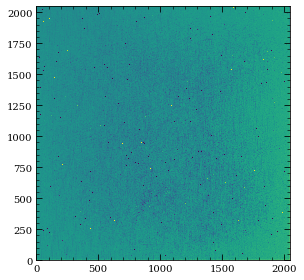

In [102]:
im = data[10]
mn = np.median(im)
std = robust.medabsdev(im)
vmin = mn - 10*std
vmax = mn + 10*std

fig, ax = plt.subplots(1,1)
ax.imshow(im, vmin=vmin, vmax=vmax)

fig.tight_layout()

In [92]:
vals = slope.flatten()
binsize = 1
bins = np.arange(vals.min(), vals.max() + binsize, binsize)
ig, vg, cv = hist_indices(vals, bins, return_more=True)

nvals = np.array([len(i) for i in ig])
ind_max = np.where(nvals==nvals.max())[0][0]
ig_max = ig[ind_max]

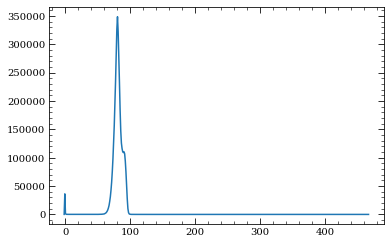

In [93]:
plt.plot(cv, nvals)

In [34]:
lxmap = [0,tarr.max()]
use_legendre = False

sat_vals = find_sat(data)
cf = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=0.98, fit_zero=False,
              use_legendre=use_legendre, lxmap=lxmap, deg=2)

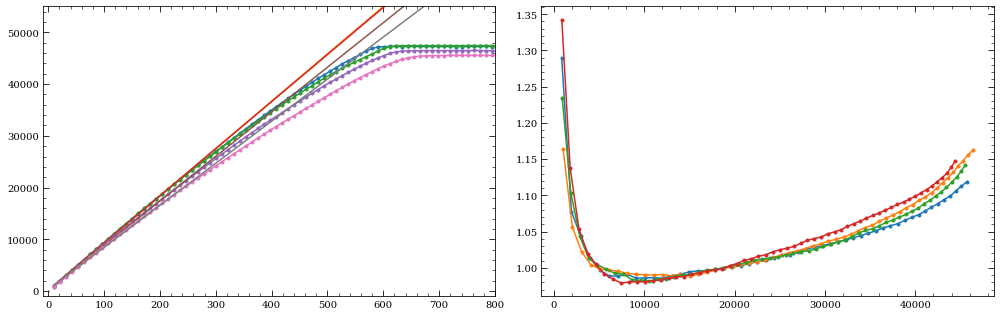

In [35]:
fig, axes = plt.subplots(1,2, figsize=(14,4.5))

for ypix in [10,100,500,1000]:

# ypix, xpix = (100,100)
    xpix = 500
    pix_vals = data[:,ypix, xpix]
    sat_lim = sat_vals[ypix, xpix]

    ax = axes[0]
    ax.plot(tarr, pix_vals, marker='.')
    dfit_lin = jl_poly(tarr, cf[:,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
#     dfit_lin = jl_poly(tarr, cf[0:2,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
#     ax.plot(tarr, dfit)
    ax.plot(tarr, dfit_lin)

    ax.set_xlim([-10,800])
    ax.set_ylim([-1000,55000])

    ax = axes[1]
    ind = pix_vals < (sat_lim*0.98)
    frac = dfit_lin / pix_vals 
    ax.plot(pix_vals[ind], frac[ind], marker='.')

fig.tight_layout()

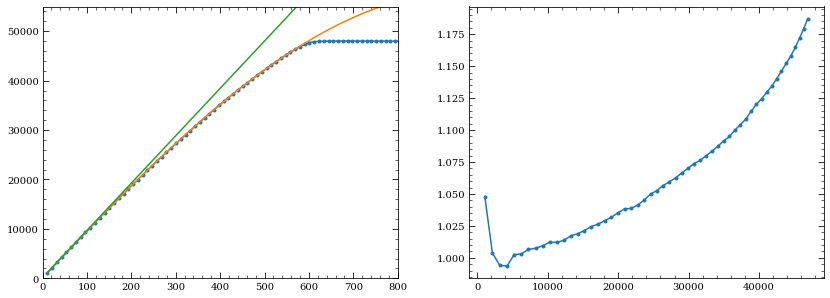

In [118]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

ypix, xpix = (100,100)
pix_vals = data[:,ypix, xpix]
sat_lim = sat_vals[ypix, xpix]

ax = axes[0]
ax.plot(tarr, pix_vals, marker='.')
dfit = jl_poly(tarr, cf[:,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
dfit_lin = jl_poly(tarr, cf[0:2,ypix, xpix], use_legendre=use_legendre, lxmap=lxmap)
ax.plot(tarr, dfit)
ax.plot(tarr, dfit_lin)

ax.set_xlim([0,800])
ax.set_ylim([0,55000])

ax = axes[1]
ind = pix_vals < (sat_lim*0.98)
frac = dfit_lin / pix_vals 
ax.plot(pix_vals[ind], frac[ind], marker='.')

In [65]:
sat_vals.ravel()[ind_good]

array([47118.31167026, 47587.57583323, 47605.09101037, ...,
       46724.80695756, 46778.99126071, 46985.86421601])

In [97]:
# mask_good = 
mn_arr = np.median(data.reshape([nz,-1])[:,ind_good], axis=1)
var_arr = robust.medabsdev(data.reshape([nz,-1])[:,ind_good], axis=1)**2

In [66]:
mn_arr = []
var_arr = []
ind_good = ig_max
sat_igood = np.mean(sat_vals.flatten()[ind_good])
for im in tqdm(data):
    im_good = im.flatten()[ind_good]
    mn = np.mean(im_good)
    if mn < sat_igood:
        mn_arr.append(mn)
        var_arr.append(np.std(im_good)**2)
    
mn_arr = np.array(mn_arr)
var_arr = np.array(var_arr)

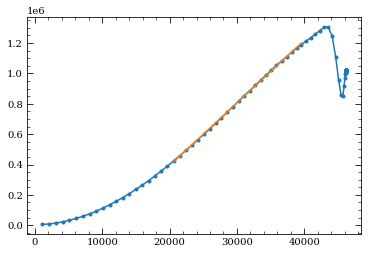

In [98]:
ifit = (mn_arr>20000) & (mn_arr<40000)
cf = jl_poly_fit(mn_arr[ifit], var_arr[ifit])

plt.plot(mn_arr, var_arr, marker='.')
plt.plot(mn_arr[ifit], jl_poly(mn_arr[ifit], cf))

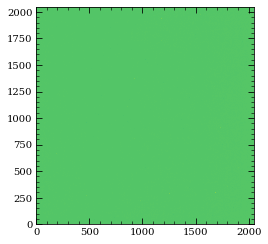

In [101]:
plt.imshow(data[0])

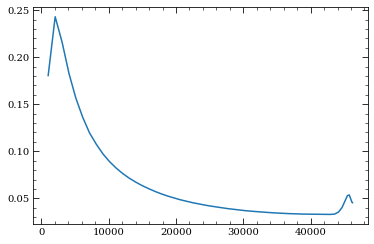

In [99]:
plt.plot(mn_arr, mn_arr/var_arr)

In [79]:
var_arr = np.std(data.reshape([nz,-1])[:,ind_good], axis=1)**2

In [81]:
mn_arr[var_arr==var_arr.max()] / sat_igood

array([0.93204084])

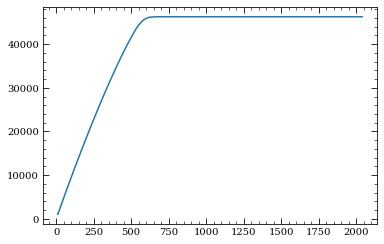

In [74]:
plt.plot(tarr, mn_arr)

In [70]:
ig_max

array([   8196,    8197,    8198, ..., 4186099, 4186100, 4186101],
      dtype=int32)

In [87]:
vals = sat_vals
binsize = 10
bins = np.arange(sat_vals.min(), sat_vals.max() + binsize, binsize)
ig, vg, cv = hist_indices(vals, bins, return_more=True)

nvals = np.array([len(i) for i in ig])

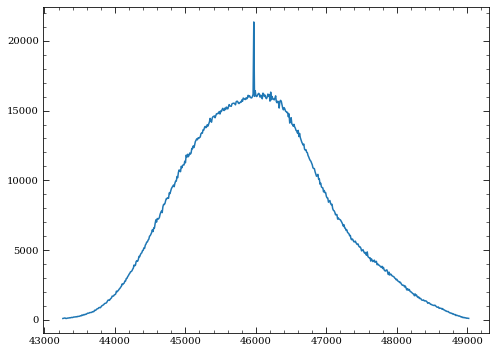

In [91]:
ind = (cv>0) & (cv<65000) & (nvals>100)
plt.plot(cv[ind], nvals[ind])

(0.0, 50000.0)

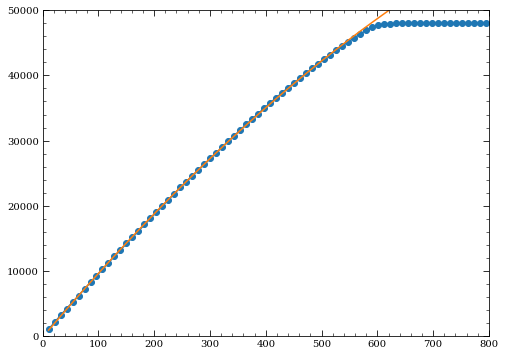

In [59]:
plt.plot(tarr, data[:,100,100], marker='o')

dfit = jl_poly(tarr, cf[:,100,100], use_legendre=True, lxmap=lxmap_arr[:,100,100])
plt.plot(tarr, dfit)

plt.xlim([0,800])
plt.ylim([0,50000])

[  10.73677   21.47354   32.21031   42.94708   53.68385   64.42062
   75.15739   85.89416   96.63093  107.3677   118.10447  128.84124
  139.57801  150.31478  161.05155  171.78832  182.52509  193.26186
  203.99863  214.7354   225.47217  236.20894  246.94571  257.68248
  268.41925  279.15602  289.89279  300.62956  311.36633  322.1031
  332.83987  343.57664  354.31341  365.05018  375.78695  386.52372
  397.26049  407.99726  418.73403  429.4708   440.20757  450.94434
  461.68111  472.41788  483.15465  493.89142  504.62819  515.36496
  526.10173  536.8385   547.57527  558.31204  569.04881  579.78558
  590.52235  601.25912  611.99589  622.73266  633.46943  644.2062
  654.94297  665.67974  676.41651  687.15328  697.89005  708.62682
  719.36359  730.10036  740.83713  751.5739   762.31067  773.04744
  783.78421  794.52098  805.25775  815.99452  826.73129  837.46806
  848.20483  858.9416   869.67837  880.41514  891.15191  901.88868
  912.62545  923.36222  934.09899  944.83576  955.57253  966.309